##Educação em geofísica
Material didático - algoritmos para aulas de geofísica
#Magnetometria - Redução ao Polo
##Método baixas latitudes
#### *Adaptação com complemento da inclinação*
#### *(MacLeod et al., 1993)*

Citação deste material: Szameitat, L.S.A., Bongiolo, A.B.S. (in prep.). Educação em geofísica: recursos computacionais para tratamento de dados magnetométricos e gravimétricos em sala de aula. Boletim Paranaense de Geociências.

####Agradecimentos
Este trabalho foi beneficiado pelas discussões com o Geól. Julio Lyrio (Petrobras) e o Físico Erico Saito Szameitat (Pólícia Científica do Paraná), aos quais as autoras agradecem pela colaboração.

####Outras Referencias
#####• Blakely, R. (1996). Potential Theory in Gravity and Magnetic Applications.Cambridge University, 464p.
#####• Bongiolo, A. B. S., de Souza, J., Ferreira, F. J. F., & de Castro, L. G. (2013). Grav mag prism: A MATLAB/octave program to generate gravity and magnetic anomalies due to rectangular prismatic bodies. Brazilian Journal of Geophysics, 31(3), 347-363.

Importar bibliotecas

In [9]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt, atan
import matplotlib.pyplot as plt
import pandas as pd

##Funções
Funções para trabalhar com os dados do campo magnético anômalo, adaptadas de Blakely (1996).

In [10]:
def DirCos(i, d, az):
    '''
    Parametros
    ----------
    i - inclinacao
    d - declinacao
    az - azimute
    '''
    a = cos(radians(i))*cos(radians(d)-radians(az))
    b = cos(radians(i))*sin(radians(d)-radians(az))
    c = sin(radians(i))
    return a, b, c

def Kvalue(i, j, nx, ny, dkx, dky):
    '''
    Parametros
    ----------
    i, j - indices
    nx, ny -  numero de amostras em x e y
    dkx, dky -
    '''
    nyqx = nx / 2 + 1
    nyqy = ny / 2 + 1
    kx = float()
    ky = float()
    if j <= nyqx:
        kx = (j-1) * dkx
    else:
        kx = (j-nx-1) * dkx
    if i <= nyqy:
        ky = (i-1) * dky
    else:
        ky = (i-ny-1) * dky
    return kx, ky

def RTPL(grid, nx, ny, dx, dy, mi1, md1, mi2, md2):
    '''
    Alterado de NewVec(grid, nx, ny, dx, dy, fi1, fd1, mi1, md1, fi2, fd2, mi2, md2)
    Objetivo: simular mudanças na direção de magnetização
    Para redução ao polo, deve-se usar mi2 = fi2 = 90
    Formula da fase para baixas latitudes em coord. polares:
    theta = atan(ky/kx)
    fase = (complex((sin(mi2)**2 - cos(mi2)**2), -(2*sin(mi2)*cos(mi2)))/complex( (sin(c)**2)+(cos(c)**2)*(cos(md1-theta)**2) ) * ( (sin(mi1)**2)*+(cos(mi1)**2)*(cos(md1-theta)**2) ))
    Parameters
    ----------
        grid - array de duas dimensões contendo o campo total
        nx, ny (int): numero de amostras em x e y
        dx, dy (int): distancia entre amostras em x e y
        mi1, md1 - (graus): inclinacao e declinacao da magnetizacao
        fi1, fd1 - (graus): Magnetizacao do campo geomagnetico atual (inclinacao, declinacao)
        mi2, md2 - (graus): Nova direção de magnetizacao (inclinaçao, declinacao)
        fi2, fd2 - (graus): Nova magnetizacao do campo geomagnetico (inclinacao, declinacao)
    '''
    #Poderiamos omitir os parametros de f ou de m, pois se assume que
    #a remanência é negligenciável (f == m). No entanto, vamos manter a
    #separação em mi e fi, e md e fd, para facilitar a compreensão e a
    #associação com as fórmulas do livro de Blakely (1996).
    fi1, fi2, fd1, fd2 = mi1, mi2, md1, md2

    dkx = 2. * np.pi / (nx * dx)
    dky = 2. * np.pi / (ny * dy)

    #Transformada de Fourier usando scipy
    gridfft = scipy.fftpack.fft2(grid) # fft2 - matriz 2D
    gridfft = np.reshape(gridfft, nx*ny) # muda a matriz fft para forma 1D

    #Filtro de fase
    if mi1 < 0:
        c = -90-mi1
    else:
        c = 90-mi1
    print ("Complemento: ", c)
    for j in range (1, nx+1):
        for i in range (1, ny+1):
            ij = (j-1) * ny + i
            if ij == 1:
                cphaseLL = 0.0
            else:
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky) # ** funcao Kvalue
                k = sqrt(kx**2 + ky**2)
                #Cossenos direcionais (projeção em x, y, z dos vetores m e f)
                mx1, my1, mz1 = DirCos(mi1, md1, 0.) # i,d do corpo, magnetização inicial
                fx1, fy1, fz1 = DirCos(fi1, fd1, 0.) # i,d do campo, magnetização inicial
                mx2, my2, mz2 = DirCos(mi2, md2, 0.) # i,d do corpo, magnetização final
                fx2, fy2, fz2 = DirCos(fi2, fd2, 0.) # i,d do campo, magnetização final
                thetam1 = complex(mz1, (kx*mx1 + ky*my1) / k)
                thetaf1 = complex(fz1, (kx*fx1 + ky*fy1) / k)
                thetam2 = complex(mz2, (kx*mx2 + ky*my2) / k)
                thetaf2 = complex(fz2, (kx*fx2 + ky*fy2) / k)
                #Condições de baixas latitudes, trabalha com o complemento de 90
                cx, cy, cz = DirCos(c, md1, 0.)
                thetam3 = complex(mz1, (-kx*mx1 - ky*my1) / k)
                thetac1 = complex(cz, (kx*cx + ky*cy) / k)
                thetac2 = complex(cz, (-kx*cx - ky*cy) / k)
                cphase = thetam2 * thetaf2 / (thetam1 * thetaf1)
                cphaseLL = cphase * (thetam1 * thetam3 / (thetac1 * thetac2))

            # Filtra cada item do grid
            gridfft[ij-1] = gridfft[ij-1]*cphaseLL
    #Fourier
    gridfft = np.reshape(gridfft, (ny, nx)) # retorna para formato 2D
    gridifft = scipy.fftpack.ifft2(gridfft)
    grid = gridifft.real #usamos apenas a parte real

    return grid

##Arquivo de entrada
Carregar arquivo de dados no ambiente. O arquivo deve conter colunas de coordenadas (x,y) e campo anômalo. O arquivo de exemplo contém uma anomalia dipolar referente ao levantamento magnetométrico realizado no sítio controlado do LPGA-UFPR (Bongiolo et al., 2022)

In [18]:
#Opção 1 - Arquivo para exercício

#Anomalia do campo magnético adquirida no Sítio Controlado LPGA-UFPR (Bongiolo et al., 2022)
arquivo = 'https://raw.githubusercontent.com/lszam/ensino/main/geof_mag/gravmagprisma.csv'

#Opção 2 - Arquivo próprio
#from google.colab import files
#import io
#uploaded=files.upload()
#arquivo = '  '#inserir o nome do arquivo nesta variável

dados = pd.read_csv(arquivo, header = 0, delimiter = ",")
dados

,LESTE,NORTE,MAG,GRAV
0,0.0,0.0,-171.271,0.222
1,10.0,0.0,-181.490,0.231
2,20.0,0.0,-191.876,0.240
3,30.0,0.0,-202.339,0.249
4,40.0,0.0,-212.772,0.259
...,...,...,...,...
2596,460.0,500.0,-194.981,0.259
2597,470.0,500.0,-183.071,0.249
2598,480.0,500.0,-171.406,0.240
2599,490.0,500.0,-160.070,0.231


Abrir e visualizar o arquivo de entrada:

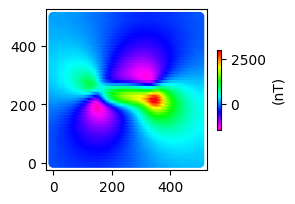

In [19]:
#Plotar
plt.figure(figsize=(3, 3))  #tamanho da figura
entrada_mag = plt.scatter(dados.LESTE, dados.NORTE, c=dados.MAG, cmap='gist_rainbow_r')
plt.colorbar(entrada_mag, label="(nT)", shrink=0.3) #barra de cores
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

### Organizando os grids de entrada (leste, norte, campo mag)

In [21]:
# .to_numpy() converte os valores de dentro da série tipo Pandas em um array NumPy
vetor_LESTE = dados.LESTE.to_numpy()
vetor_NORTE = dados.NORTE.to_numpy()
vetor_CMA = dados.MAG.to_numpy()

#Elementos a leste e a norte
pontos_LESTE=[]
pontos_NORTE=[]

#Adicionar valores não repetidos
[pontos_LESTE.append(item) for item in vetor_LESTE if not pontos_LESTE.count(item)]
[pontos_NORTE.append(item) for item in vetor_NORTE if not pontos_NORTE.count(item)]

#Salvar número de itens a leste e a norte
n_l = np.size(pontos_LESTE)
n_n = np.size(pontos_NORTE)

#Obter a distancia em x e y
dX, dY = np.abs(pontos_LESTE[0]-pontos_LESTE[1]), np.abs(pontos_NORTE[0]-pontos_NORTE[1])

#Grid
grid_LESTE, grid_NORTE = np.meshgrid(pontos_LESTE, pontos_NORTE) #mesh
grid_CMA = np.reshape(vetor_CMA, (n_n, n_l)) #de 1D para 2D

#Salva as posições dos prismas como array
pontos_LESTE = np.array(pontos_LESTE)
pontos_NORTE = np.array(pontos_NORTE)


# Redução ao polo

Definir parâmetros e aplicar a transformação no dado

In [22]:
mi1 = int(11)
md1 = int(-18)
mi2 = 90 #rtp
md2 = 0 #rtp

#Transformação
grid_RTP = RTPL(grid_CMA, n_l, n_n, dX, dY, mi1, md1, mi2, md2)

dados = dados.assign(RTP = np.reshape(grid_RTP, (n_l*n_n)))
dados

Complemento:  79


,LESTE,NORTE,MAG,GRAV,RTP
0,0.0,0.0,-171.271,0.222,333.165239
1,10.0,0.0,-181.490,0.231,288.025732
2,20.0,0.0,-191.876,0.240,308.322063
3,30.0,0.0,-202.339,0.249,299.030908
4,40.0,0.0,-212.772,0.259,319.354785
...,...,...,...,...,...
2596,460.0,500.0,-194.981,0.259,-126.771844
2597,470.0,500.0,-183.071,0.249,-120.179303
2598,480.0,500.0,-171.406,0.240,-46.848295
2599,490.0,500.0,-160.070,0.231,-15.157351


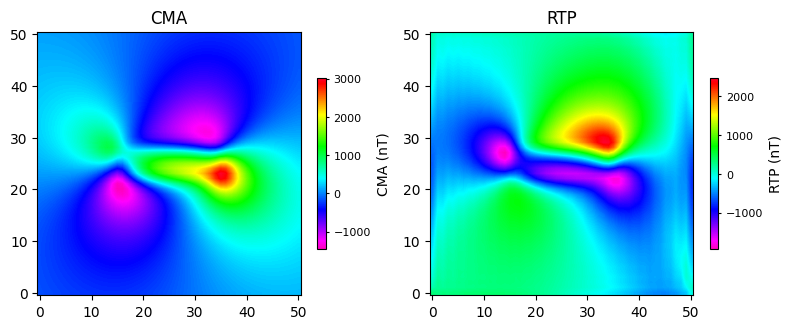

In [23]:
#Exibir mapas do dado de entrada e de saída
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.title("CMA")
mapa_cma = plt.imshow(grid_CMA, interpolation='bilinear', cmap='gist_rainbow_r')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
colorbar_cma = plt.colorbar(mapa_cma, label="CMA (nT)", shrink=0.3)
colorbar_cma.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_cma.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.title("RTP")
mapa_rtp = plt.imshow(grid_RTP, interpolation='bilinear', cmap='gist_rainbow_r')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
colorbar_rtp = plt.colorbar(mapa_rtp, label="RTP (nT)", shrink=0.3)
colorbar_rtp.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_rtp.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.tight_layout()

#Salvar figura
plt.savefig('mag_rtp_py.png', dpi=300, bbox_inches='tight')

plt.show()

Salvar a saída como arquivo csv

In [ ]:
dados.to_csv("mag_rtpll_py.csv")